In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.transforms as tt
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
import cv2
from PIL import Image

from pathlib import Path

In [2]:
DATA_ROOT = Path('gesture_250302024/')

In [3]:
tmp_ds = ImageFolder(DATA_ROOT)
CLASSES_NAME = tmp_ds.classes
CLASSES_NAME

['L', 'OK', 'first', 'palm', 'peace']

In [ ]:
Let's set the transformations for the train and the test.
For Grayscale, we set the number of output layers to 3,
because resnet does not accept single channel images

In [4]:
train_tfms = tt.Compose([
                         tt.Grayscale(num_output_channels=3), # Pictures black and white
                         tt.Resize([128, 128]),
                         # Settings for expanding the dataset
                         tt.RandomHorizontalFlip(),           # Random 90 degree rotations
                         tt.RandomRotation(30),               # Random 30 degree rotations
                         tt.ToTensor(),                      # Cast to tensor
                         ])                      

test_tfms = tt.Compose([
                        tt.Grayscale(num_output_channels=3),
                        tt.Resize([128, 128]),
                        tt.ToTensor(),
                        ])
     

In [ ]:
Let's create training and test datasets with the same images, but with different preprocessing:

In [6]:
train_ds_list = []
test_ds_list = []
for dir in os.listdir(DATA_ROOT):
    train_ds = ImageFolder(os.path.join(DATA_ROOT), train_tfms)
    test_ds = ImageFolder(os.path.join(DATA_ROOT), test_tfms)
    train_ds_list.append(train_ds)
    test_ds_list.append(test_ds)

train_ds = ConcatDataset(train_ds_list)
test_ds = ConcatDataset(test_ds_list)

In [ ]:
Total number of pictures:

In [8]:
LEN_DS = len(train_ds)
LEN_DS

5000

In [ ]:
The function to convert the class number to its name:

In [10]:
def digit_to_classname(digit):
    for idx, itm in enumerate(CLASSES_NAME):
        if idx == digit:
            return itm

In [ ]:
Let's look at the distribution of classes in the dataset:

This code first counts the number of samples in each class in the training set using the Counter class from the collections module. The Counter object is then used to create a bar plot showing the class distribution in the training set.

Similar code can be used to visualize the class distribution in the test set.

Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000})


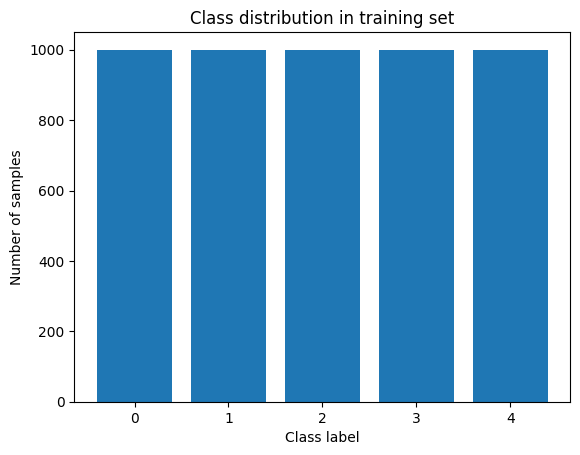

In [11]:
from collections import Counter

train_counts = Counter([label for _, label in train_ds])
print(train_counts)

import matplotlib.pyplot as plt
plt.bar(train_counts.keys(), train_counts.values())
plt.xlabel('Class label')
plt.ylabel('Number of samples')
plt.title('Class distribution in training set')
plt.show()

In [ ]:
Class distribution is equal.

In [12]:
torch.manual_seed(1)

val_split = 0.2
split = int(LEN_DS * val_split)
indices = torch.randperm(LEN_DS)

train_ds = torch.utils.data.Subset(train_ds, indices[split:])
test_ds = torch.utils.data.Subset(test_ds, indices[:split])

len(train_ds), len(test_ds)

(4000, 1000)

In [ ]:
Let's check the dimension of the random tensor in the dataset:

In [13]:
train_ds[3000][0].size()

torch.Size([3, 128, 128])

In [ ]:
Let's create dataloaders:

In [15]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2)
test_dl = DataLoader(test_ds, batch_size, num_workers=1, shuffle=False)

In [ ]:
Let's display a random image in the test loader:

torch.Size([3, 128, 128])
tensor(2) first


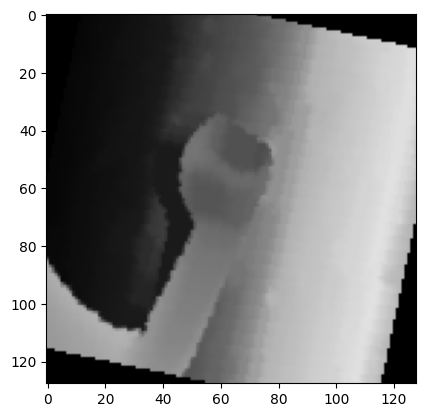

In [16]:
for img, l in train_dl:
    print(img[0].shape)
    print(l[0], digit_to_classname(l[0]))
    plt.imshow(img[0].permute(1, 2, 0)) #, cmap='gray')
    break

In [ ]:
Function for batch visualization:

In [17]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([3, 128, 128])


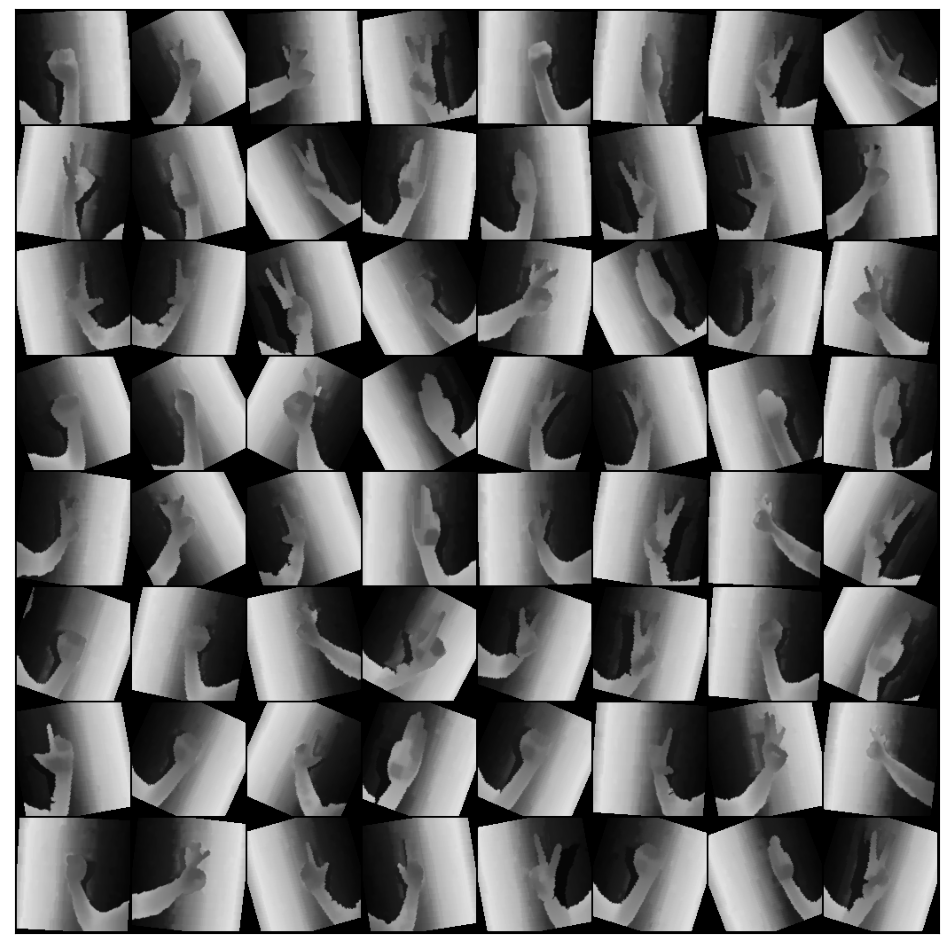

In [18]:
show_batch(train_dl)

In [ ]:
Let's define a device for the operation of neural networks:

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
Let's take a pre-trained network resnet50 for classification:

In [20]:
resnet = models.resnet50(pretrained=True)
summary(resnet.to(device), input_size=(3, 128, 128))

C:\Users\Adel\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Adel\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
Forbid weights to learn

In [21]:
for param in resnet.parameters():
    param.requires_grad = False

In [22]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
Let's overwrite the last classification layer,
and make sure that the rest of the layers will not be trained:

In [23]:
in_features = resnet.fc.in_features
fc = nn.Linear(in_features=in_features, out_features=len(CLASSES_NAME))
resnet.fc = fc

summary(resnet.to(device), input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
Let's create a list of trainable parameters and feed it to the optimizer.
We also initialize the loss function:

In [24]:
params_to_update = []
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

        
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
We initialize the function for training the network:

In [ ]:
from time import time

def train(model,
          criterion,
          optimizer,
          train_dataloader,
          test_dataloader,
          print_every,
          num_epoch):
    steps = 0
    train_losses, val_losses = [], []

    model.to(device)
    for epoch in range(num_epoch):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()
        
        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Logging
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss {running_loss / steps:.3f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
                with torch.no_grad():
                    model.eval()
                    correct_val, total_val = 0, 0
                    val_loss = 0
                    for images, labels in test_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)
                        output = model(images)
                        loss = criterion(output, labels)
                        val_loss += loss.item()

                        correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                        total_val += labels.size(0)

                print(f'Val loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')
                print(f'Took {time() - iter_time:.3f} seconds')
                iter_time = time()

                train_losses.append(running_loss / total_train)
                val_losses.append(val_loss / total_val)


        print(f'Epoch took {time() - start_time}') 
        torch.save(model, f'checkpoint_{correct_val / total_val * 100:.2f}')
        
    return model, train_losses, val_losses

In [ ]:
Let's train the network on 10 epochs:

In [ ]:
#print_every = 50
num_epoch = 20

resnet, train_losses, val_losses = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dl,
    test_dataloader=test_dl,
    print_every=print_every,
    num_epoch=num_epoch
)

In [25]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

In [26]:
_input = Input((224,224,1)) 

In [27]:
conv1  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(_input)
conv2  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(conv1)
pool1  = MaxPooling2D((2, 2))(conv2)

conv3  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(pool1)
conv4  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(conv3)
pool2  = MaxPooling2D((2, 2))(conv4)

conv5  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool2)
conv6  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv5)
conv7  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv6)
pool3  = MaxPooling2D((2, 2))(conv7)

conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool3)
conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv8)
conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv9)
pool4  = MaxPooling2D((2, 2))(conv10)

conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv11)
conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv12)
pool5  = MaxPooling2D((2, 2))(conv13)

flat   = Flatten()(pool5)
dense1 = Dense(4096, activation="relu")(flat)
dense2 = Dense(4096, activation="relu")(dense1)
output = Dense(1000, activation="softmax")(dense2)

vgg16_model  = Model(inputs=_input, outputs=output)

In [28]:
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt 
from PIL import Image 
import seaborn as sns
import pandas as pd 
import numpy as np 
import os 

img1 = "../input/flowers-recognition/flowers/tulip/10094729603_eeca3f2cb6.jpg"
img2 = "../input/flowers-recognition/flowers/dandelion/10477378514_9ffbcec4cf_m.jpg"
img3 = "../input/flowers-recognition/flowers/sunflower/10386540696_0a95ee53a8_n.jpg"
img4 = "../input/flowers-recognition/flowers/rose/10090824183_d02c613f10_m.jpg"
imgs = [img1, img2, img3, img4]

def _load_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img 

def _get_predictions(_model):
    f, ax = plt.subplots(1, 4)
    f.set_size_inches(80, 40)
    for i in range(4):
        ax[i].imshow(Image.open(imgs[i]).resize((200, 200), Image.ANTIALIAS))
    plt.show()
    
    f, axes = plt.subplots(1, 4)
    f.set_size_inches(80, 20)
    for i,img_path in enumerate(imgs):
        img = _load_image(img_path)
        preds  = decode_predictions(_model.predict(img), top=3)[0]
        b = sns.barplot(y=[c[1] for c in preds], x=[c[2] for c in preds], color="gray", ax=axes[i])
        b.tick_params(labelsize=55)
        f.tight_layout()

In [ ]:
from keras.applications.vgg16 import VGG16
vgg16_weights = '../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
vgg16_model = VGG16(weights=vgg16_weights)
_get_predictions(vgg16_model)

In [1]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3
from keras.applications import VGG16

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading the dataset
def loading_the_data(data_dir):
    # Generate data paths with labels
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            
            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)
    
    return df

In [3]:
# loading the data
data_dir = 'gesture_250302024'
df = loading_the_data(data_dir)

df

,filepaths,labels
0,gesture_250302024\first\1.png,first
1,gesture_250302024\first\10.png,first
2,gesture_250302024\first\100.png,first
3,gesture_250302024\first\101.png,first
4,gesture_250302024\first\102.png,first
...,...,...
995,gesture_250302024\peace\95.png,peace
996,gesture_250302024\peace\96.png,peace
997,gesture_250302024\peace\97.png,peace
998,gesture_250302024\peace\98.png,peace


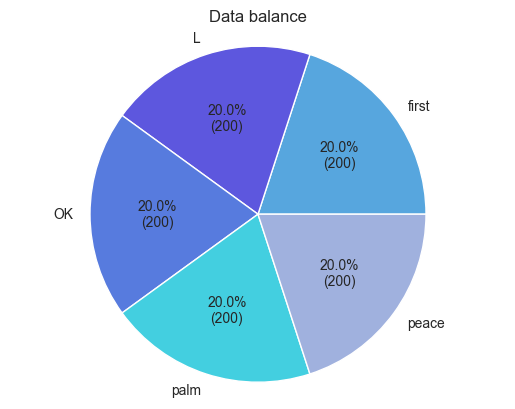

In [4]:
data_balance = df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#57A6DE","#5D57DE","#577BDE","#43CFE0","#A0B1DE"])
plt.title("Data balance")
plt.axis("equal")
plt.show()

In [5]:
# data --> 80% train data && 20% (test, val)
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

# test data --> 10% train data && 10% (test, val)
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [6]:
batch_size = 16
img_size = (224, 224)

# Create generators for the data
tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)


# Convert the data
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 800 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.


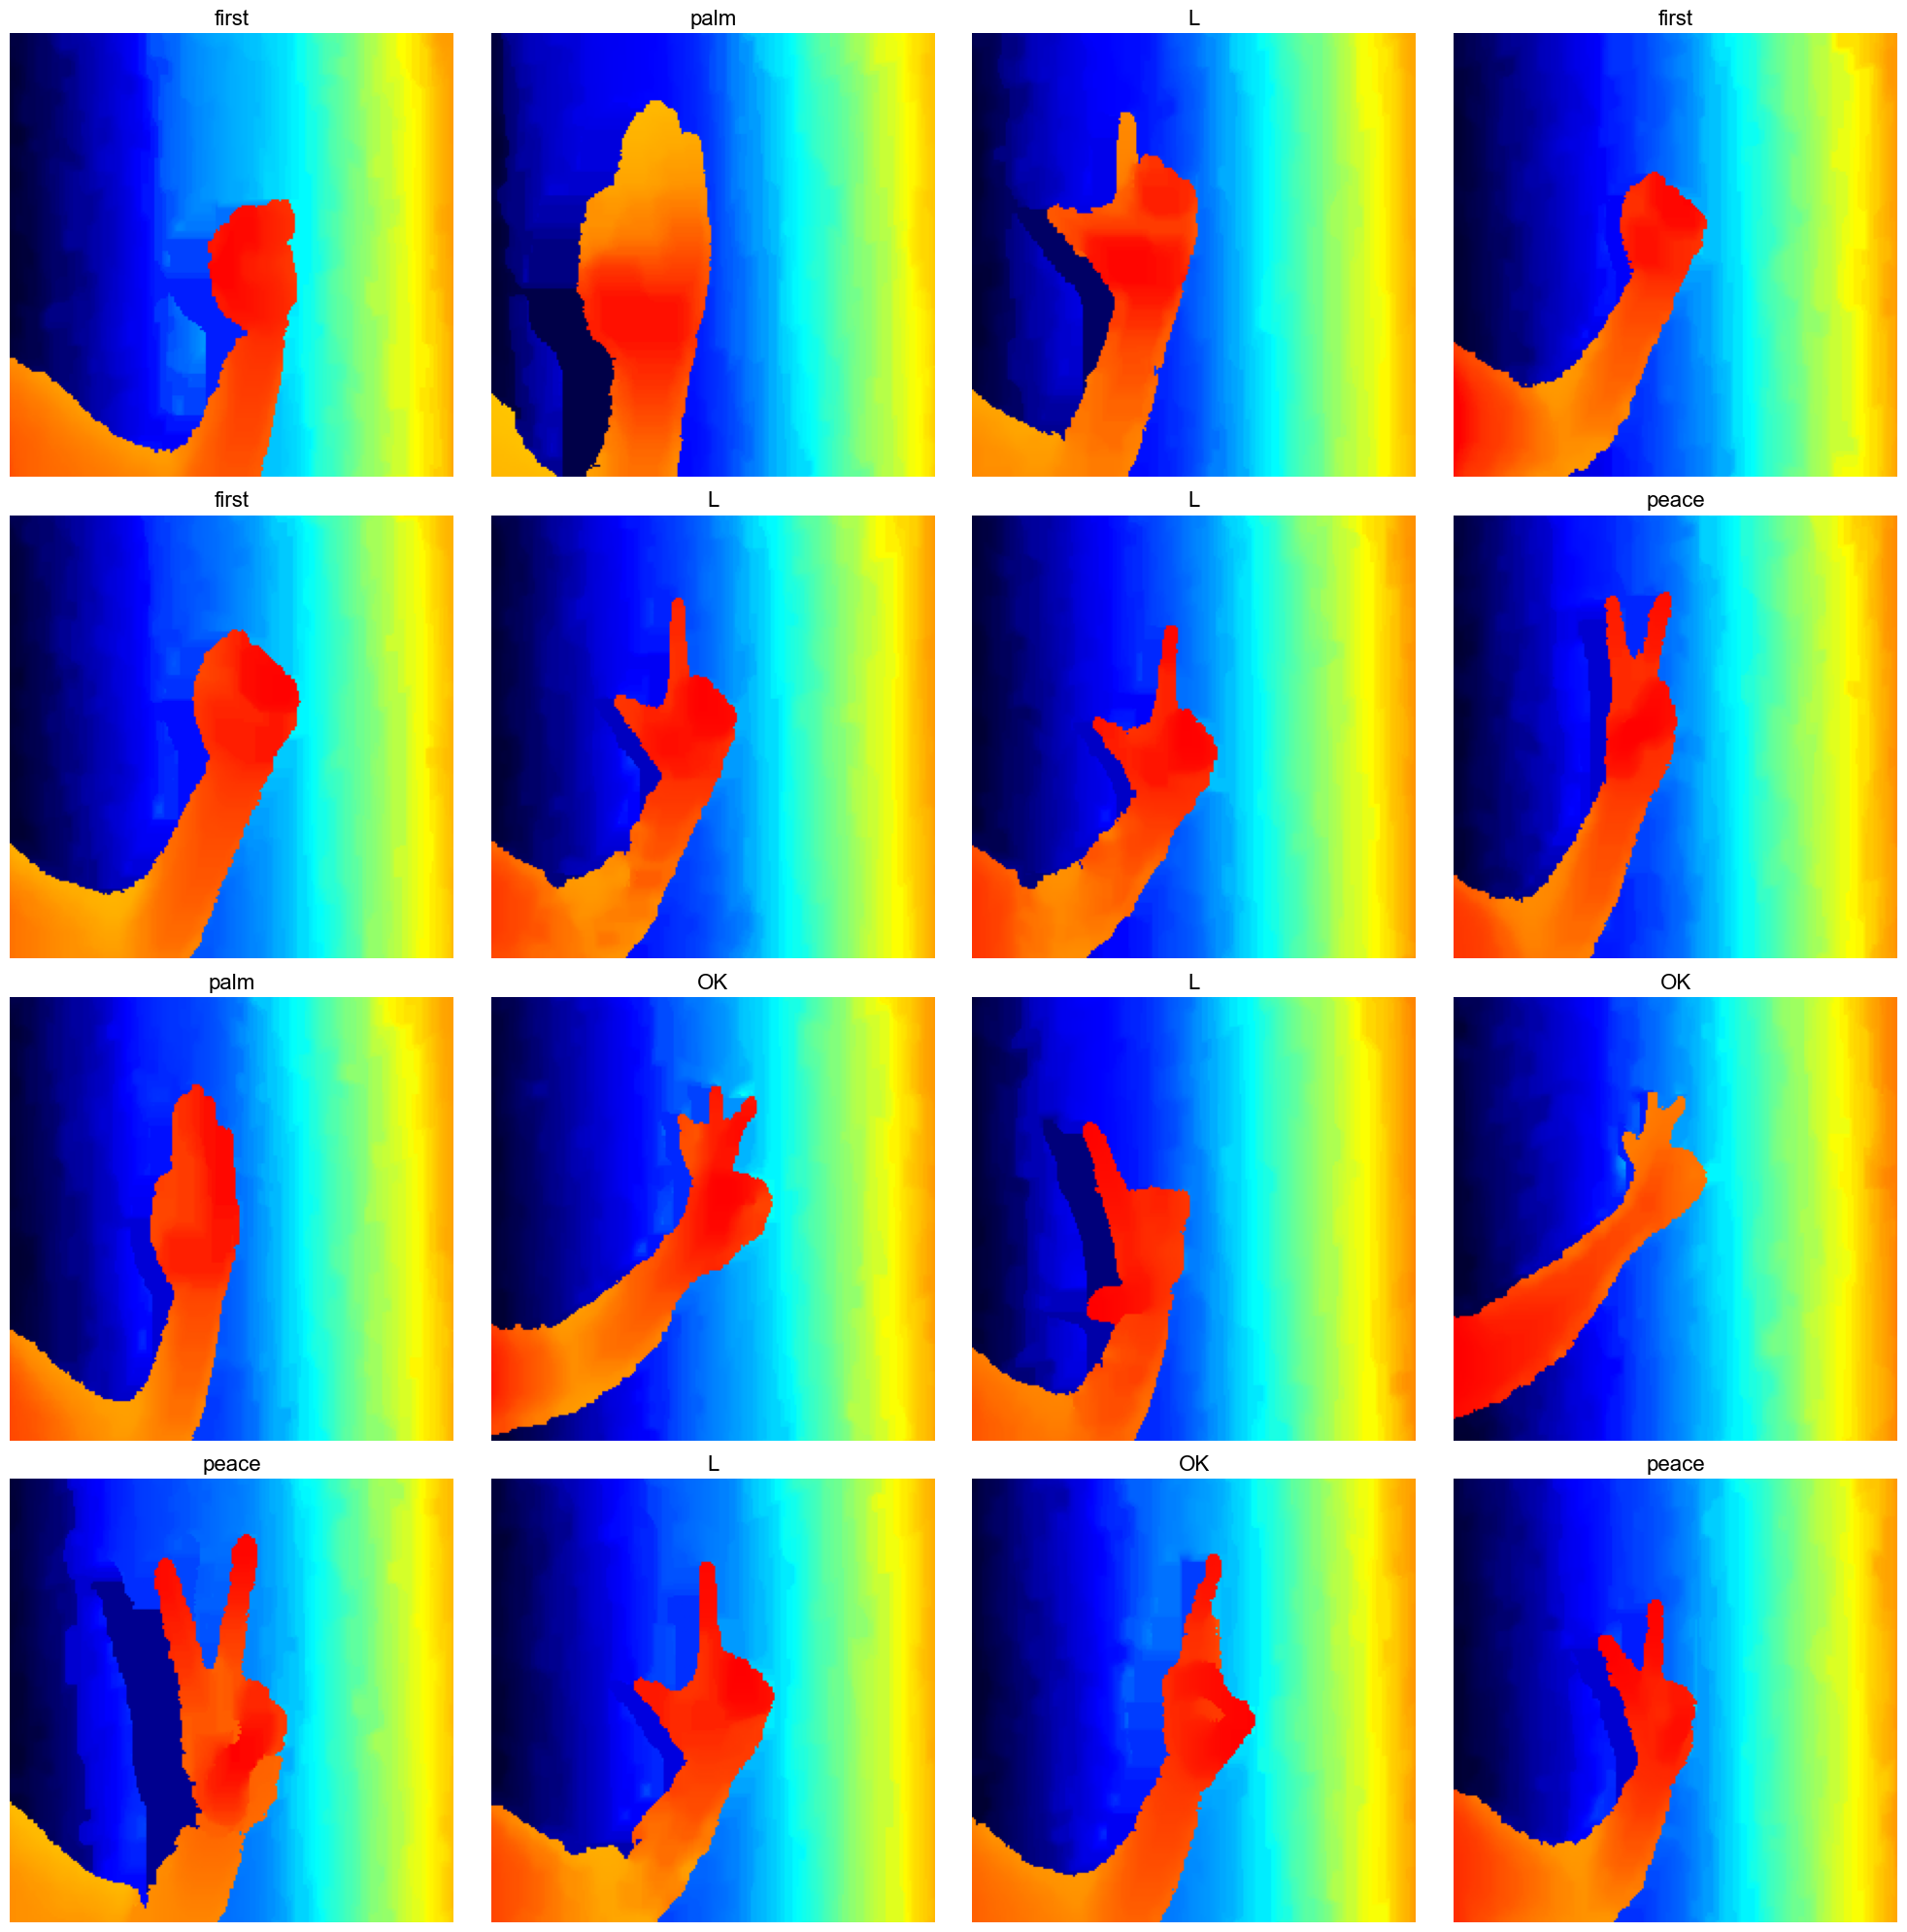

In [7]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
# Displaying the model performance
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    Epochs = [i+1 for i in range(len(tr_acc))]
    
    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()
    

# Evaluate the model
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)
    
    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])
    

# Get Predictions
def get_pred(model, test_gen):
    
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)
    
    return y_pred


# Confusion Matrix
def plot_confusion_matrix(test_gen, y_pred):
    
    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())
    
    # Display the confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.show()
    
    
# Defining a convolutional NN block for a sequential CNN model
def conv_block(filters, act='relu'):
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D())
    
    return block


# Defining a dense NN block for a sequential CNN model
def dense_block(units, dropout_rate, act='relu'):
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [9]:
# create Model structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = len(list(train_gen.class_indices.keys()))     # to define number of classes in dense layer

In [10]:
# Model architecture
cnn_model = Sequential()

# first conv block
cnn_model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D())

# second conv block
cnn_model.add(conv_block(32))

# third conv block
cnn_model.add(conv_block(64))

# fourth conv bolck
cnn_model.add(conv_block(128))

# fifth conv block
cnn_model.add(conv_block(256))

# sixth conv block
cnn_model.add(conv_block(512))

# flatten layer
cnn_model.add(Flatten())

# first dense block
cnn_model.add(dense_block(256, 0.5))

# second dense block
cnn_model.add(dense_block(128, 0.3))

# third dense block
cnn_model.add(dense_block(64, 0.2))

# fourth dense block
cnn_model.add(dense_block(32, 0.2))

# output layer
cnn_model.add(Dense(class_counts, activation = "softmax"))

In [11]:
cnn_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 sequential_1 (Sequential)   (None, 56, 56, 32)        14016     
                                                                 
 sequential_2 (Sequential)   (None, 28, 28, 64)        55680     
                                                                 
 sequential_3 (Sequential)   (None, 14, 14, 128)       2

In [12]:
# train the model
epochs = 20   # number of all epochs in training

history = cnn_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/20


50/50 [==============================] - 20s 313ms/step - loss: 1.5934 - accuracy: 0.3825 - val_loss: 1.9749 - val_accuracy: 0.2500
Epoch 2/20
50/50 [==============================] - 15s 293ms/step - loss: 1.1707 - accuracy: 0.5188 - val_loss: 2.1751 - val_accuracy: 0.1800
Epoch 3/20
50/50 [==============================] - 15s 293ms/step - loss: 0.9423 - accuracy: 0.6363 - val_loss: 3.8202 - val_accuracy: 0.1800
Epoch 4/20
50/50 [==============================] - 15s 293ms/step - loss: 0.8154 - accuracy: 0.6975 - val_loss: 5.4203 - val_accuracy: 0.1800
Epoch 5/20
50/50 [==============================] - 15s 300ms/step - loss: 0.6559 - accuracy: 0.7725 - val_loss: 6.5326 - val_accuracy: 0.1800
Epoch 6/20
50/50 [==============================] - 15s 296ms/step - loss: 0.6371 - accuracy: 0.7962 - val_loss: 7.5259 - val_accuracy: 0.1800
Epoch 7/20
50/50 [==============================] - 15s 308ms/step - loss: 0.4755 - accuracy: 0.8525 - val_loss: 9.7353 - val_accuracy: 0.18

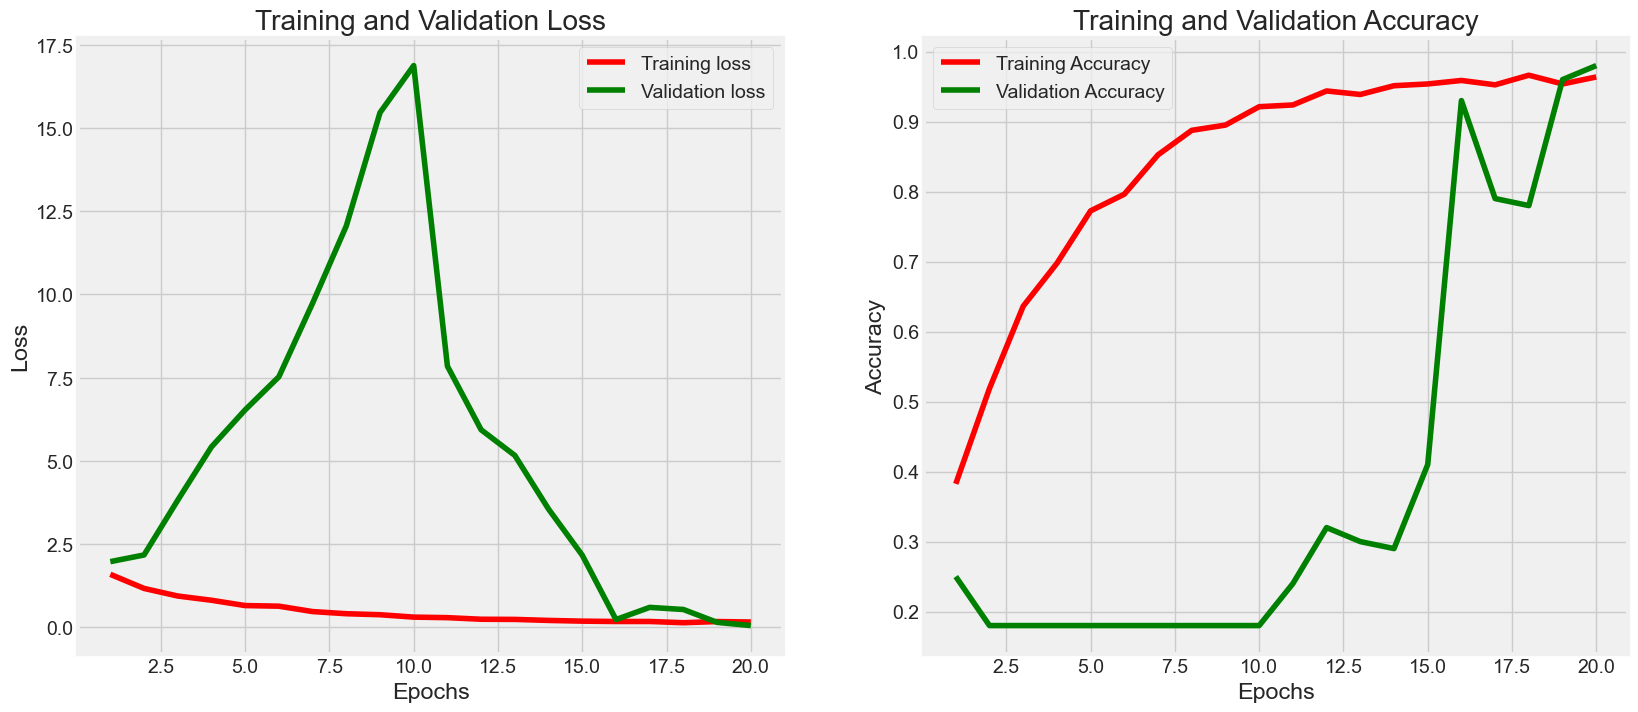

In [13]:
# Display model performance
model_performance(history, epochs)

In [14]:
# Model evaluation
model_evaluation(cnn_model)

7/7 [==============================] - 1s 87ms/step - loss: 0.0509 - accuracy: 0.9800
Train Loss:  0.013079162687063217
Train Accuracy:  1.0
--------------------
Validation Loss:  0.05475671589374542
Validation Accuracy:  0.9800000190734863
--------------------
Test Loss:  0.050896693021059036
Test Accuracy:  0.9800000190734863


In [ ]:
Get predictions and display the confusion matrix

7/7 [==============================] - 1s 87ms/step


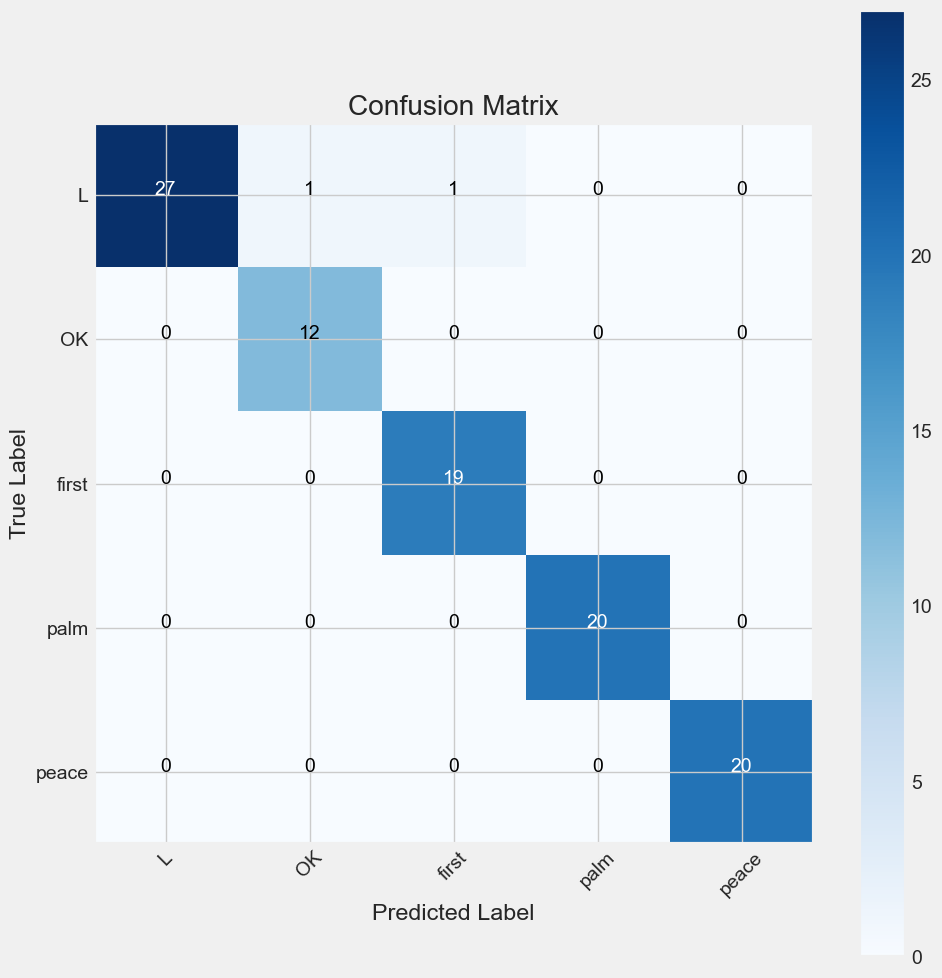

In [15]:
# get predictions
y_pred = get_pred(cnn_model, test_gen)

# plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred)

In [ ]:
VGG16

In [16]:
# get the pre-trained model (VGG16)
base_model = VGG16(weights='imagenet', include_top=False, input_shape = img_shape, pooling= 'max')

# freeze four convolution blocks
for layer in base_model.layers[:15]:
    layer.trainable = False
    
    
# fine-tune VGG16 (Adding some custom layers on top)
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.2)(x)   # # Dropout layer to prevent overfitting
x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(32, activation = 'relu')(x)
predictions = Dense(class_counts, activation = "sigmoid")(x)    # output layer with softmax activation

# the model
VGG16_model = Model(inputs = base_model.input, outputs = predictions)

In [17]:
VGG16_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

VGG16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
# Check the trainable status of the layers
for layer in VGG16_model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
global_max_pooling2d True
flatten_1 True
dense_5 True
dropout_4 True
dense_6 True
dense_7 True
dense_8 True
dense_9 True


In [19]:
# train the model
epochs = 20   # number of all epochs in training

VGG16_history = VGG16_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/20
50/50 [==============================] - 57s 1s/step - loss: 0.3421 - accuracy: 0.6675 - val_loss: 0.1067 - val_accuracy: 0.9600
Epoch 2/20
50/50 [==============================] - 55s 1s/step - loss: 0.0753 - accuracy: 0.9688 - val_loss: 0.0203 - val_accuracy: 1.0000
Epoch 3/20
50/50 [==============================] - 55s 1s/step - loss: 0.0296 - accuracy: 0.9862 - val_loss: 0.0076 - val_accuracy: 1.0000
Epoch 4/20
50/50 [==============================] - 54s 1s/step - loss: 0.0139 - accuracy: 0.9962 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 5/20
50/50 [==============================] - 55s 1s/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 6/20
50/50 [==============================] - 55s 1s/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 7/20
50/50 [==============================] - 55s 1s/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 8/20
50/50 [==

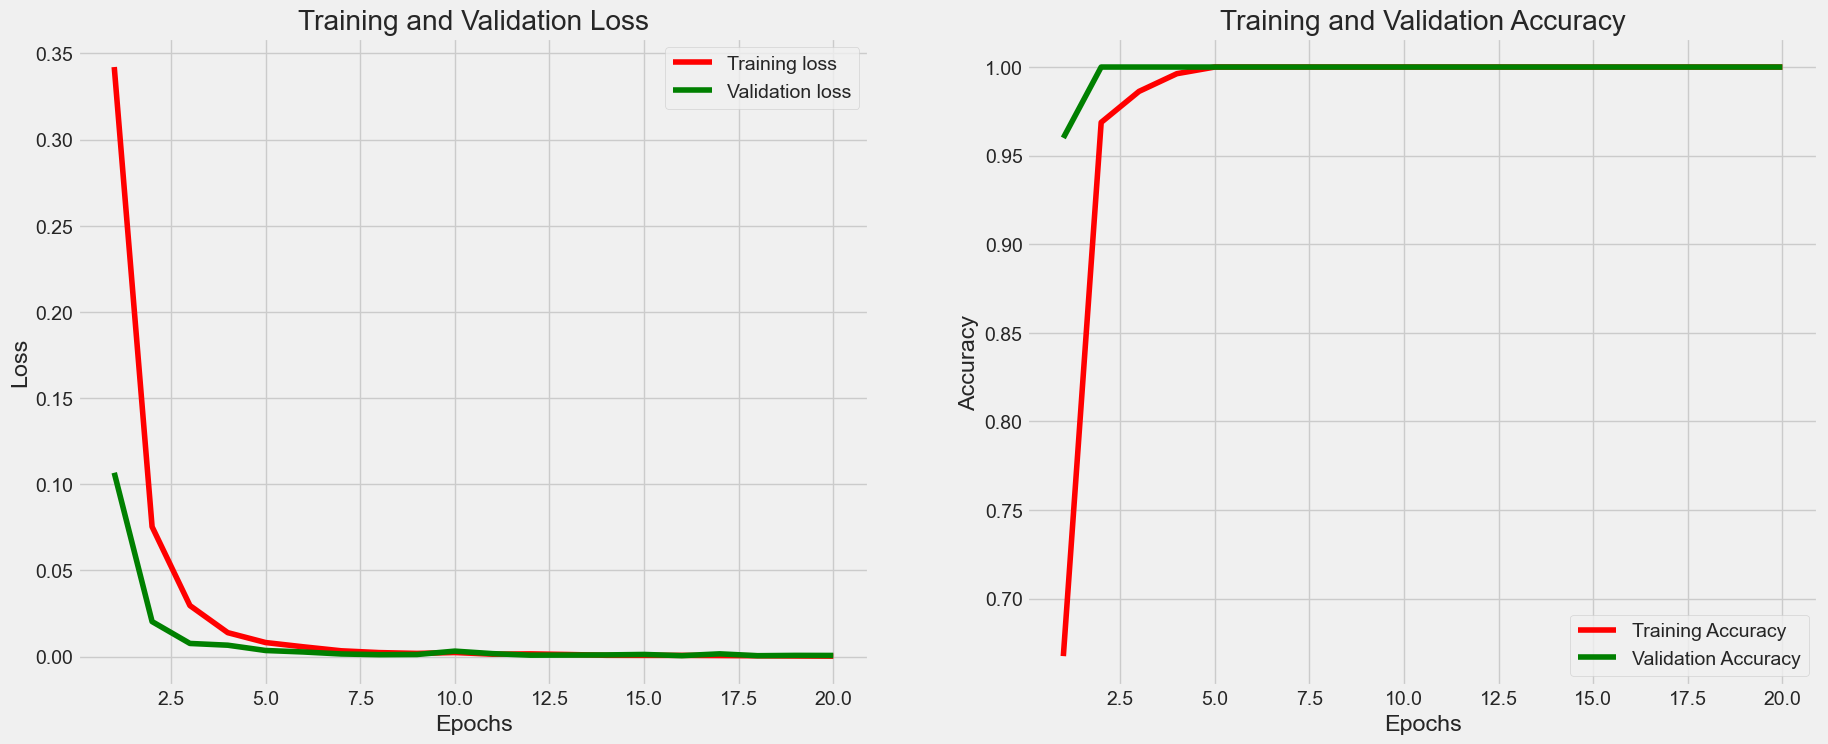

In [20]:
# Display model performance
model_performance(VGG16_history, epochs)

In [21]:
# Model evaluation
model_evaluation(VGG16_model)

7/7 [==============================] - 5s 709ms/step - loss: 8.0255e-05 - accuracy: 1.0000
Train Loss:  4.0144943341147155e-05
Train Accuracy:  1.0
--------------------
Validation Loss:  0.0006240695365704596
Validation Accuracy:  1.0
--------------------
Test Loss:  8.025483111850917e-05
Test Accuracy:  1.0


7/7 [==============================] - 5s 733ms/step


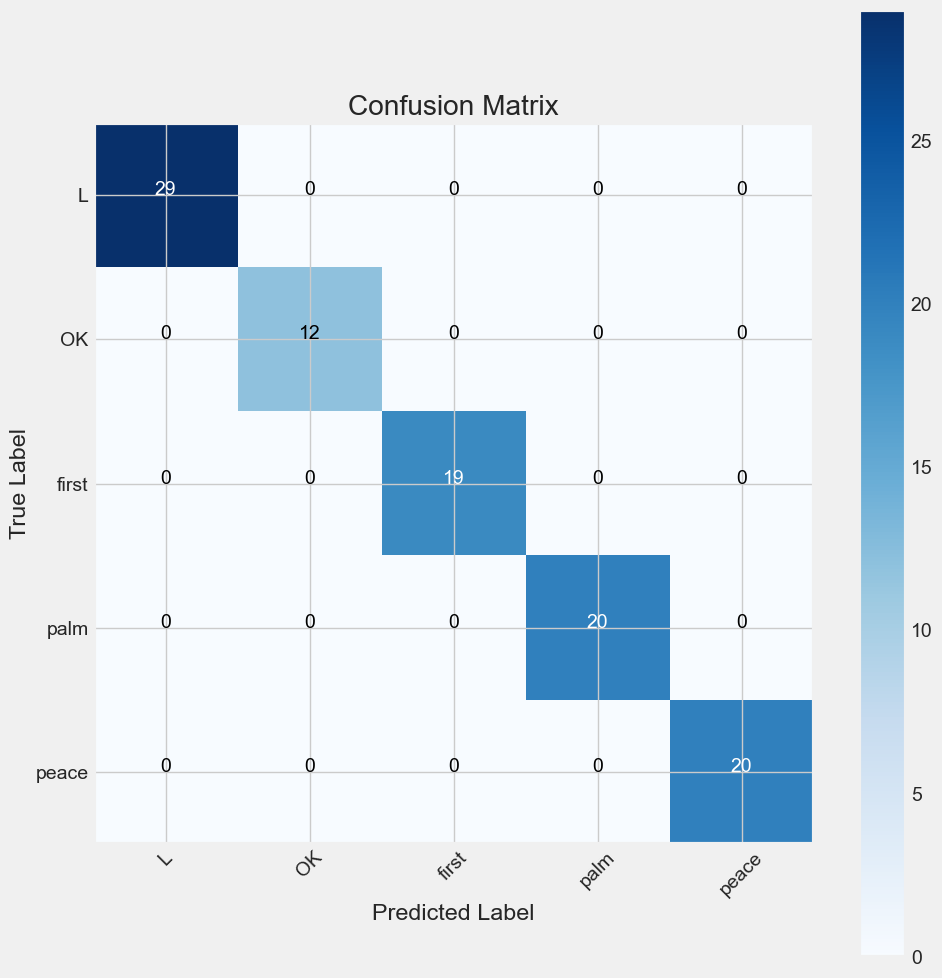

In [22]:
# get predictions
y_pred = get_pred(VGG16_model, test_gen)

# plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred)